# 02-prepare-spacy-docs

## Main Objectives

- Creating SpaCy format datasets for training and testing/validation
- Selection of a subset of data for training (defined by NUM_TEXTS)
- Saving to disk for subsequent model training notebooks


In [1]:
!python -m spacy download en_core_web_lg --user

2021-03-22 15:09:43.822412: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [1]:
import spacy
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import spacy

import matplotlib.pyplot as plt
%matplotlib inline

# DocBin is spacys new way to store Docs in a 
# binary format for training later
from spacy.tokens import DocBin

yelp_test_df=pd.read_csv('yelp_test_df.csv').dropna()
yelp_train_df=pd.read_csv('yelp_train_df.csv').dropna()

# load a medium sized english language model in spacy
nlp = spacy.load("en_core_web_lg")
# tok2vec = nlp.add_pipe("tok2vec")

# we are so far only interested in the first 5000 reviews
# this will keep the training time short.
NUM_TEXTS = 5000
NUM_TEXTS_SMALL = 100

## Verify we have an equal number of positive and negative polarities

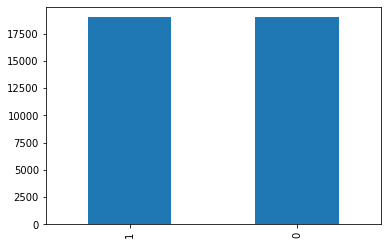

In [2]:
ax=yelp_test_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
#fig.savefig("test-scores.png")

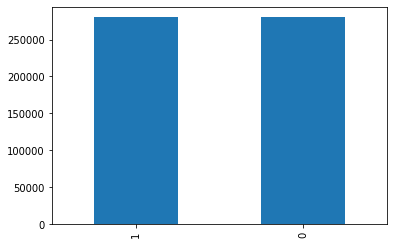

In [3]:
ax=yelp_train_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
#fig.savefig("train-scores.png")

## make_docs(data)

- transforms tuple list of a dataset into SpaCy doc format

In [4]:
def make_docs(data):
    """
    this will take a list of texts and labels 
    and transform them in spacy documents
    data: list(tuple(text, label))
    returns: List(spacy.Doc.doc)
    """
    docs = []
    # nlp.pipe([texts]) is way faster than running 
    # nlp(text) for each text
    # as_tuples allows us to pass in a tuple, 
    # the first one is treated as text
    # the second one will get returned as it is.    
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        # we need to set the (text)cat(egory) for each document
        if label == 1:
            doc.cats['positive'] = 1.0
            doc.cats['negative'] = 0.0
        else:
            doc.cats['positive'] = 0.0
            doc.cats['negative'] = 1.0
        
        docs.append(doc)
        #print(doc.cats)
    # put them into a nice list
    return docs

## Get our csv data into the tuple list format, make sure and keep an equal number of positive and negative, inspect and plot for verification

In [8]:
train_pos_df=yelp_train_df[yelp_train_df.Score==1][:int(NUM_TEXTS/2)]
train_neg_df=yelp_train_df[yelp_train_df.Score==0][:int(NUM_TEXTS/2)]
train_pos_sm_df=yelp_train_df[yelp_train_df.Score==1][:int(NUM_TEXTS_SMALL/2)]
train_neg_sm_df=yelp_train_df[yelp_train_df.Score==0][:int(NUM_TEXTS_SMALL/2)]

train_df=train_pos_df.append(train_neg_df)
train_sm_df=train_pos_sm_df.append(train_neg_sm_df)

#np.random.shuffle(train_df)

train_df['tuples'] = train_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
train = train_df['tuples'].tolist()
np.random.shuffle(train)

train_sm_df['tuples'] = train_sm_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
train_sm = train_sm_df['tuples'].tolist()
np.random.shuffle(train_sm)

print(train_df.shape)
print(train_sm_df.shape)
train[:2]
#train_df.head()

(5000, 4)
(100, 4)


[('great find frequent nearby bryant street restaurant know place exist friend bring today hot chocolate immediately fall love barista friendly hot chocolate great incredibly delicious look pastry need soon try nice ambience quiet uncomfortable great place study read visit friend expect wait minute drink worth :-)',
  1),
 ('parking suck smell way way overpriced bag price 15 apparently donate yard sale tag 3 lot junk cash place atm clothe sort color cool',
  0)]

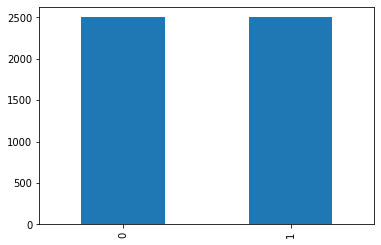

In [9]:
ax=train_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
#fig.savefig("train-scores.png")

In [10]:
test_pos_df=yelp_test_df[yelp_test_df.Score==1][:int(NUM_TEXTS/2)]
test_neg_df=yelp_test_df[yelp_test_df.Score==0][:int(NUM_TEXTS/2)]
test_df=test_pos_df.append(test_neg_df)
test_pos_sm_df=yelp_test_df[yelp_test_df.Score==1][:int(NUM_TEXTS_SMALL/2)]
test_neg_sm_df=yelp_test_df[yelp_test_df.Score==0][:int(NUM_TEXTS_SMALL/2)]
test_sm_df=test_pos_sm_df.append(test_neg_sm_df)

test_df['tuples'] = test_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
test = test_df['tuples'].tolist()
np.random.shuffle(test)
print(test_df.shape)
test_sm_df['tuples'] = test_sm_df.apply(
    lambda row: (row['Text'],row['Score']), axis=1)
test_sm = test_sm_df['tuples'].tolist()
np.random.shuffle(test_sm)
print(test_sm_df.shape)

test[:2]
#test_df.head()


(5000, 4)
(100, 4)


[('new favorite ht crowd worth selection hts price price different ht 3 mile away ht definitely notice difference location light look bright clean love shiny ht matthews local produce selection high price win suppose',
  1),
 ('great girl time daughter mani pedi love offer service menu like sushi restaurant foot soft cnd shellac french manicure kelly nice answer question great job p.s. leave daughter realize toe smudge fix smile :) definitely',
  1)]

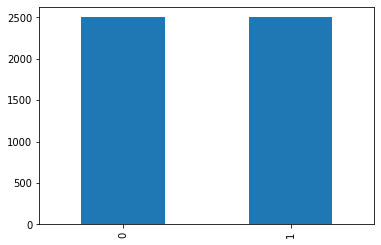

In [11]:
ax=test_df.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()
#fig.savefig("test-scores.png")

# Save our SpaCy formatted docs for subsequent training notebooks

In [12]:
# first we need to transform all the training data
train_docs = make_docs(train[:NUM_TEXTS])
# then we save it in a binary file to disc
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("./data/train.spacy")

# repeat for validation data
valid_docs = make_docs(test[:NUM_TEXTS])
doc_bin = DocBin(docs=valid_docs)
doc_bin.to_disk("./data/dev.spacy")

# first we need to transform all the training data
train_sm_docs = make_docs(train_sm[:NUM_TEXTS])
# then we save it in a binary file to disc
doc_bin = DocBin(docs=train_sm_docs)
doc_bin.to_disk("./data/train_sm.spacy")

# repeat for validation data
valid_sm_docs = make_docs(test_sm[:NUM_TEXTS])
doc_bin = DocBin(docs=valid_sm_docs)
doc_bin.to_disk("./data/dev_sm.spacy")



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
!ls data

dev_sm.spacy  dev.spacy  train_sm.spacy  train.spacy


In [14]:
train_docs[:2]

[great find frequent nearby bryant street restaurant know place exist friend bring today hot chocolate immediately fall love barista friendly hot chocolate great incredibly delicious look pastry need soon try nice ambience quiet uncomfortable great place study read visit friend expect wait minute drink worth :-),
 parking suck smell way way overpriced bag price 15 apparently donate yard sale tag 3 lot junk cash place atm clothe sort color cool]